# Hyperparameer Tuning - Churn

## Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(style="whitegrid")
sns.set_context("notebook")

In [3]:
from IPython.display import Markdown, display

OUT = "output"
import os
os.makedirs(OUT, exist_ok=True)
SHOW_PLOTS = True
TEST_TRAIN_SEED = 666

def summarise_dataframe(df):
    display(Markdown("\n**Dataframe (%s x %s)**\n" % df.shape), df.head())
    display(Markdown("\n**Missing Values**"), df.isna().sum())
    display(Markdown("\n**dtypes**"), df.dtypes)

In [4]:
display_fraction = lambda n,d: (n/d*100, n, d)

## Load and Prepare the Data 

Here we load the previously cleaned and merged dataset from _data_ folder or load the original dataset and perform the usual steps.

In [5]:
FORCE = True 
DEBUG = False
if not os.path.isdir("data"): os.makedirs("data", exist_ok=True)
    
if FORCE or not os.path.isfile("data/churn.csv"):
    
    # load and prep Churn dataset
    df_churn = pd.read_csv("src/churn.csv")
    if DEBUG: summarise_dataframe(df_churn)
    # fix column names
    names = df_churn.columns.tolist()
    CORRECTIONS = {" ":"_", "'":"", "?":"", "CustServ":"Cust_Serv"}
    def fixName(s):
        for a,b in CORRECTIONS.items():
            s = s.replace(a,b)
        return s
    mapping = {c:fixName(c) for c in names}
    df_churn.rename(columns=mapping, inplace=True)
    # encode categatorical features and target 
    df_churn.Intl_Plan = df_churn.Intl_Plan.map( {"yes":1, "no":0} )
    df_churn.VMail_Plan = df_churn.VMail_Plan.apply( lambda x: int(x=='yes') )
    df_churn.Churn = df_churn.Churn.apply( lambda x: int(x=="True.") )
    
    # # load and prep State dataset
    df_states = pd.read_csv("src/states.csv")
    
    df_churn = df_churn.merge(df_states,on='State')
    
    # save perpared dataset
    df_churn.to_csv("data/churn.csv", index=False)

# always (reload) written datset
df_all = pd.read_csv("data/churn.csv")
summarise_dataframe(df_all)


**Dataframe (3333 x 24)**


,State,Account_Length,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,Cust_Serv_Calls,Churn,Latitude,Longitude,Name
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,91,11.01,10.0,3,2.70,1,0,39.011902,-98.484246,Kansas
1,KS,70,408,411-4582,0,0,0,232.1,122,39.46,...,112,9.05,0.0,0,0.00,3,0,39.011902,-98.484246,Kansas
2,KS,92,408,386-4170,1,0,0,62.6,111,10.64,...,80,9.98,10.4,2,2.81,1,1,39.011902,-98.484246,Kansas
3,KS,137,408,352-8202,0,0,0,205.9,88,35.00,...,84,13.05,14.5,4,3.92,2,0,39.011902,-98.484246,Kansas
4,KS,132,415,369-3214,0,0,0,83.4,110,14.18,...,114,6.60,7.6,5,2.05,1,0,39.011902,-98.484246,Kansas



**Missing Values**

State              0
Account_Length     0
Area_Code          0
Phone              0
Intl_Plan          0
VMail_Plan         0
VMail_Message      0
Day_Mins           0
Day_Calls          0
Day_Charge         0
Eve_Mins           0
Eve_Calls          0
Eve_Charge         0
Night_Mins         0
Night_Calls        0
Night_Charge       0
Intl_Mins          0
Intl_Calls         0
Intl_Charge        0
Cust_Serv_Calls    0
Churn              0
Latitude           0
Longitude          0
Name               0
dtype: int64


**dtypes**

State               object
Account_Length       int64
Area_Code            int64
Phone               object
Intl_Plan            int64
VMail_Plan           int64
VMail_Message        int64
Day_Mins           float64
Day_Calls            int64
Day_Charge         float64
Eve_Mins           float64
Eve_Calls            int64
Eve_Charge         float64
Night_Mins         float64
Night_Calls          int64
Night_Charge       float64
Intl_Mins          float64
Intl_Calls           int64
Intl_Charge        float64
Cust_Serv_Calls      int64
Churn                int64
Latitude           float64
Longitude          float64
Name                object
dtype: object

## Pre-Processing Data

Next drop columns that are of no benefit 

In [6]:
target = "Churn"
attributes_initial = df_churn.columns.tolist()
attributes_initial.remove(target) 

attributes_initial = [a for a in attributes_initial if a not in ["Phone", "Area_Code", "Name"] and a[-6:]!="Charge"]

print("Initial features are %s" % attributes_initial)

df_model = df_all.loc[:, attributes_initial + [target]]

Initial features are ['State', 'Account_Length', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Eve_Mins', 'Eve_Calls', 'Night_Mins', 'Night_Calls', 'Intl_Mins', 'Intl_Calls', 'Cust_Serv_Calls', 'Latitude', 'Longitude']


In [7]:
df_model.head()

,State,Account_Length,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,Night_Calls,Intl_Mins,Intl_Calls,Cust_Serv_Calls,Latitude,Longitude,Churn
0,KS,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,39.011902,-98.484246,0
1,KS,70,0,0,0,232.1,122,292.3,112,201.2,112,0.0,0,3,39.011902,-98.484246,0
2,KS,92,1,0,0,62.6,111,180.6,126,221.7,80,10.4,2,1,39.011902,-98.484246,1
3,KS,137,0,0,0,205.9,88,209.3,86,289.9,84,14.5,4,2,39.011902,-98.484246,0
4,KS,132,0,0,0,83.4,110,232.2,137,146.7,114,7.6,5,1,39.011902,-98.484246,0


### Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=TEST_TRAIN_SEED)

## Feature_Engineering 

Features engineering and selection decisions are carried out on __df_train__ ONLY, but resulting operations should be applied to both __df_train__ and __df_test__. The simplest way to do this (without repeating code) is to apply operations to __df_model__ and repeat the train/test split USING THE SAME SEED.

Note: Features here are not optimal just wanted a simple common start point for all.

### Plans

In [9]:
df_model["Plans_Both"] = df_model.apply (lambda row: (row.Intl_Plan and row.VMail_Plan), axis=1)
df_model["Plans_Intl_Only"] = df_model.apply (lambda row: (row.Intl_Plan and not row.VMail_Plan), axis=1)
df_model["Plans_VMail_Only"] = df_model.apply (lambda row: (not row.Intl_Plan and row.VMail_Plan), axis=1)
df_model["Plans_None"] = df_model.apply (lambda row: (not row.Intl_Plan and not row.VMail_Plan), axis=1)

### Cust_Serv_Calls => Happy/Unhappy Customers

D:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


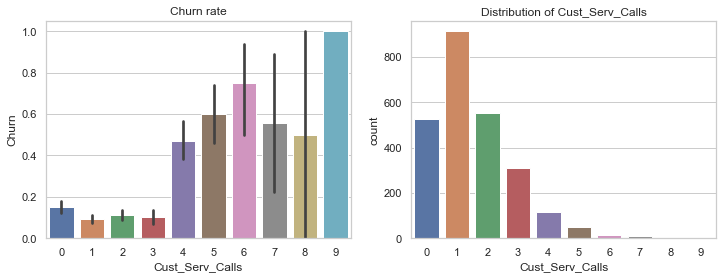

In [10]:
if SHOW_PLOTS:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.barplot(x="Cust_Serv_Calls", y="Churn", data=df_train)
    plt.title("Churn rate")
    plt.subplot(1,2,2)
    sns.countplot(x="Cust_Serv_Calls", data=df_train)
    plt.title("Number of calls")
    plt.title("Distribution of Cust_Serv_Calls")
    plt.show()

The above graph shows:
 * Low churn rate for those with less than 4 calls $\implies$ Binarisation for happy customer.
 * Expect increasing trend as __Cust_Serv_Calls__ increases and think that drop for 7 and  8 is due to small sample size.
 * For 9 (and possibly more) service calls everybody churns $\implies$ Consider binary variable for unhappy customer
 

In [11]:
df_model["Cust_Happy"] = df_model.Cust_Serv_Calls<4
df_model["Cust_Unhappy"] = df_model.Cust_Serv_Calls>=4
df_model["Cust_Serv_Calls_Mod"] = df_model.Cust_Serv_Calls.apply ( lambda x: int(x>4)*x )

### Usage

Based on scatter plots in ETA it appears only day usage seems to be linked to churn. But when summing over all and seeing a relatively constant churn rate decided to go with Total usage.

In [12]:
df_model["Total_Mins"] = sum (df_model[d+"_Mins"] for d in ["Day", "Eve", "Night", "Intl"])
df_model["Total_Calls"] = sum (df_model[d+"_Calls"] for d in ["Day", "Eve", "Night", "Intl"])
df_model["Cust_Low"] = df_model.Total_Mins<340
df_model["Cust_High"] = df_model.Total_Mins<680

D:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`

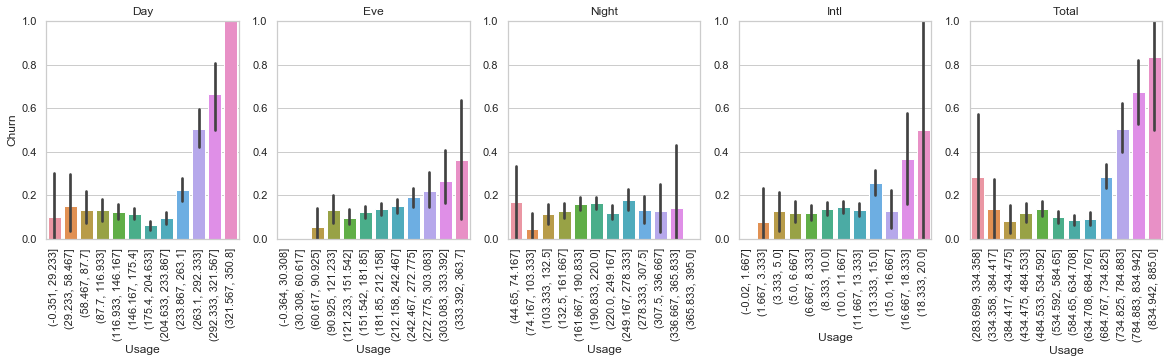

In [13]:
# redo split because I have added new feature 
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=TEST_TRAIN_SEED)
df = df_train.copy()

if SHOW_PLOTS:
    plt.figure(figsize=(20,4))
    for k, d in enumerate(["Day", "Eve", "Night", "Intl", "Total"]):
        plt.subplot(1,5,k+1)
        df["Usage"] = pd.cut(df[d+"_Mins"], bins=12)
        ax = sns.barplot(data=df, x="Usage", y="Churn")
        ax.set_title(d)
        ax.set_ylim(0,1)
        for tick in ax.get_xticklabels(): tick.set_rotation(90)
        if k: ax.set_ylabel("")
    plt.show()

### Average length of Calls

Not sure if these features will be of benefit, mainly inserting them because they are easy to understand feature, and "just in case".

In [14]:
for d in ["Day", "Eve", "Night", "Intl", "Total"]:
    df_model[d+"_Min_Per_Call"] = df_model[d+"_Mins"] / df_model[d+"_Calls"]
df_model.fillna(value=0,inplace=True)

### Length of account

In [15]:
df_model["Account_Length_Binned"] = df_model.Account_Length.apply(lambda x: int(x)//60)
df_model["Shortterm_Account"] = df_model.Account_Length_Binned==0

D:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


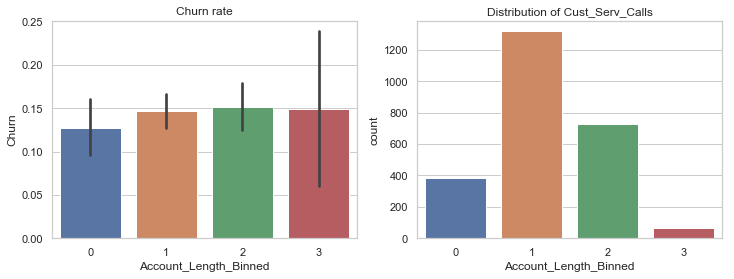

In [16]:
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=TEST_TRAIN_SEED)

if SHOW_PLOTS:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.barplot(x="Account_Length_Binned", y="Churn", data=df_train)
    plt.title("Churn rate")
    plt.subplot(1,2,2)
    sns.countplot(x="Account_Length_Binned", data=df_train)
    plt.title("Number of calls")
    plt.title("Distribution of Cust_Serv_Calls")
    plt.show()

### Usage and plans 

In [17]:
df_model["High_Day_and_No_VMail_Plan"] = df_model.apply (lambda row: (row.Day_Mins>200 and row.VMail_Plan == 0), axis=1)
df_model["Low_Night_and_no_Intl_Plan"] = df_model.apply (lambda row: (row.Night_Mins<=250 and row.Intl_Plan ==1), axis=1)

### State

Want to group states into high/mid/low churn rates.

In [18]:
df = df_train.loc[:,["State","Churn"]].groupby("State").mean()
df = df.reset_index()

In [19]:
groups = 3 
from sklearn.cluster import AgglomerativeClustering
X_train = df.loc[:,["Churn"]]
clustering = AgglomerativeClustering(n_clusters=groups).fit(X_train)
df["Group"] = clustering.labels_
for g in range(groups):
    print ("Group %s has range %.3f .. %.3f" % (g, df.loc[df.Group==g].Churn.min(), df.loc[df.Group==g].Churn.max()))
df.groupby("Group").count()

Group 0 has range 0.051 .. 0.138
Group 1 has range 0.208 .. 0.261
Group 2 has range 0.154 .. 0.173


,State,Churn
Group,,
0,30,30
1,13,13
2,8,8


In [20]:
df_model['State_Group'] = df.Group
df_model['State_Low'] = df_model.State_Group==2
df_model['State_Mid'] = df_model.State_Group==0
df_model['State_High'] = df_model.State_Group==1
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=TEST_TRAIN_SEED)

## Model Training

### Train-Test Split

REPEAT train/test split from above so that both data subsets have the modified feature set.

In [21]:
attributes = df_model.columns.tolist()
#attributes = attributes_initial

for column in [target, "State", "Longitude", "Latitude", "State_Group"]:
    if column in attributes: attributes.remove(column)

df_model.fillna(value=0,inplace=True)
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=42)
print(attributes)

['Account_Length', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Eve_Mins', 'Eve_Calls', 'Night_Mins', 'Night_Calls', 'Intl_Mins', 'Intl_Calls', 'Cust_Serv_Calls', 'Plans_Both', 'Plans_Intl_Only', 'Plans_VMail_Only', 'Plans_None', 'Cust_Happy', 'Cust_Unhappy', 'Cust_Serv_Calls_Mod', 'Total_Mins', 'Total_Calls', 'Cust_Low', 'Cust_High', 'Day_Min_Per_Call', 'Eve_Min_Per_Call', 'Night_Min_Per_Call', 'Intl_Min_Per_Call', 'Total_Min_Per_Call', 'Account_Length_Binned', 'Shortterm_Account', 'High_Day_and_No_VMail_Plan', 'Low_Night_and_no_Intl_Plan', 'State_Low', 'State_Mid', 'State_High']


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,attributes].astype(float))
y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,attributes].astype(float))
y_test = df_test.Churn.values

### Training using recall

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('clf', LogisticRegression(solver='liblinear'))
])

param_grid = [
    {'clf__C': np.logspace(-4, 4,20), 'clf__penalty': ['l1', 'l2']}
]

gs = GridSearchCV(estimator=pipeline, iid=False,
    return_train_score=True,
    param_grid=param_grid, scoring='recall', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7733483483483483
{'clf__C': 0.0001, 'clf__penalty': 'l2'}


In [24]:
SEED=42
from sklearn.svm import SVC

pipeline = Pipeline([('clf', SVC(random_state=SEED))])

param_range = np.logspace(-4,4,10)
param_grid = [
    {'clf__gamma': param_range,'clf__C': param_range,  'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipeline, iid=False,
    return_train_score=True,
    param_grid=param_grid, scoring='recall', cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7045045045045046
{'clf__C': 10000.0, 'clf__gamma': 0.000774263682681127, 'clf__kernel': 'rbf'}


In [25]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)

param_grid = [{
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : np.linspace(1, 20, 20),
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_split' : range(2,15),
    'min_samples_leaf' : range(2,5)
}]

gs = GridSearchCV(estimator=clf, iid=False, return_train_score=True, param_grid=param_grid, scoring='recall', cv=10,n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.6850600600600601
{'criterion': 'entropy', 'max_depth': 18.0, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'best'}


### Training using problem specific metric

### Scorer Function

In [26]:
from sklearn.metrics import confusion_matrix, make_scorer

def customScore(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    # people who churn and take the offer lose 1025
    # peope who would churn but take the offer and stay gain 975
    # people who leave and don't take the offer lose 1000
    # people who won't churn but take the offer lose 25
    # people who leave but I didn't notice till there gone lose 1000
    return ((((cm[1,1] * 0.9) * 0.3) * -1025) + (((cm[1,1] * 0.9) * 0.7) * 975) + ((cm[1,1] * 0.1) * -1000) + ((cm[0,1] * 0.6) * -25) + (cm[1, 0] * -1000) + cm[0,0] * 1000) / cm.sum()

scorer = make_scorer(customScore, greater_is_better=True)


### SVC With RandomSearch

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

clf = SVC(random_state=42)

param_grid = { 'gamma' : np.logspace(-4,4,10), 'C' : np.logspace(-4,4,10), 'kernel' : ['rbf']}

gs = RandomizedSearchCV(estimator=clf, iid=False, return_train_score=True, param_distributions=param_grid, n_iter=50, random_state=SEED, scoring=scorer, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

816.3595472887566
{'kernel': 'rbf', 'gamma': 0.000774263682681127, 'C': 1291.5496650148827}


### LogisticRegression with random search and custom scorer

In [31]:
'''
pipeline = Pipeline([('clf', SVC(random_state=SEED))])

param_range = np.logspace(-4,4,10)
param_grid = [{'clf__gamma': param_range,'clf__C': param_range,  'clf__kernel': ['rbf']}]
gs = RandomizedSearchCV(estimator=pipeline, iid=False, return_train_score=True, param_distributions=param_grid, scoring=scorer, cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
'''

clf = LogisticRegression(solver='liblinear')

param_grid = {'C' : np.logspace(-4, 4, 20),
             'penalty' : ['l1', 'l2']}

gs = RandomizedSearchCV(estimator=clf, iid=False, 
                        return_train_score=True, 
                        param_distributions=param_grid,
                        n_iter=40, random_state=42,
                        scoring=scorer, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

743.354020064321
{'penalty': 'l2', 'C': 0.00026366508987303583}


Decision Tree with custom scorer and random search

In [35]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)

param_grid = {'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : np.linspace(1, 20, 20),
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_split' : range(2,15),
    'min_samples_leaf' : range(2,5)}

gs = RandomizedSearchCV(estimator=clf, iid=False, 
                        return_train_score=True, 
                        param_distributions=param_grid,
                        n_iter=50, random_state=42,
                        scoring=scorer, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

798.3806342821485
{'splitter': 'best', 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 16.0, 'criterion': 'gini'}
